# Disclaimer
If you use this code for any other purpose than checking for my errors, you are just insane as it was not tested.

# Buhlmann
This notebook builds up on the basic Buhlmann implementation at this link: [Buhlmann](./buhlmann.ipynb)

# Finding the ceiling with Gradient Factors
With gradient factors, you interpolate between this line and the ambient line.

The ambient line is: $y=x$.

If we use $GF=80\%$, we just draw a vertical line for a certain $P_{amb tol}$ and take 80% between the ambiant line and
the Buhlmann tissue line.

So we can compute what would be $P_{tissue,tol}^{GF}$:

$P_{tissue,tol}^{GF} = P_{amb tol} + GF\left(P_{tissue,tol}-P_{amb tol}\right)$

This can be written as:

$P_{tissue,tol}^{GF} = P_{amb tol}\left( 1 + GF\left( \frac{1}{b}-1 \right) \right)+a \cdot GF$

Therefore:

$ceiling^{GF}= \frac{P_{tissue,tol}^{GF} - a \cdot GF}{1 + GF\left( \frac{1}{b}-1 \right)}$

We have an optional argument in the ceiling function to compute a ceiling with gradient factor:

In [1]:
from buhlmann import ceiling_pressure, Tissues, pressure_to_depth
initial_tissues = Tissues()
for gf_pc in list(range(0 , 110, 10)):
    print("GF={}, ceiling={}".format(
        gf_pc/100.0,
        pressure_to_depth(ceiling_pressure(initial_tissues, gf=gf_pc/100.0))))


GF=0.0, ceiling=-2.547929999999999
GF=0.1, ceiling=-2.806488783715432
GF=0.2, ceiling=-3.063201934707479
GF=0.3, ceiling=-3.3180891443154206
GF=0.4, ceiling=-3.5711698247513213
GF=0.5, ceiling=-3.8224631140283916
GF=0.6, ceiling=-4.071987880785298
GF=0.7, ceiling=-4.319762729008982
GF=0.8, ceiling=-4.565806002658449
GF=0.9, ceiling=-4.810135790191965
GF=1.0, ceiling=-5.052769928999998


Usually the diver defines two variables $GF_{lo}$ and $GF_{hi}$.

$GF_{lo}$ is used on the first stop.

$GF_{hi}$ is used on the last stop when surfacing.

Between these points, we interpolate linearly the $GF$.

To make it easier, we will just encapsulate this in a class.

In [2]:
class GradientFactorsNB:
    def __init__(self, gf_lo, pamb_lo, gf_hi, pamb_hi=1):
        """
        :param gf_lo: gradient factor for first stop, usually between 0 and 1
        :param pamb_lo: ambiant pressure for the first stop
        :param gf_hi:  gradient factor for surfacing stop, usually between 0 and 1
        :param pamb_hi: ambiant pressure for the surface, assume 1 bar by default ?
        """
        self.gf_lo = gf_lo
        self.pamb_lo = pamb_lo
        self.gf_hi = gf_hi
        self.pamb_hi = pamb_hi

    def gf(self, pamb):
        return self.gf_lo + \
               (self.gf_hi - self.gf_lo) / (self.pamb_hi - self.pamb_lo) \
               * (pamb - self.pamb_lo)

gf = GradientFactorsNB(0.5, 5, 0.8)
for p in range(1, 6):
    print("pressure={}, GF={}".format(p, gf.gf(p)))


pressure=1, GF=0.8
pressure=2, GF=0.7250000000000001
pressure=3, GF=0.65
pressure=4, GF=0.575
pressure=5, GF=0.5


We have a parameter to find stops with gradient factors in the function `buhlmann.get_stops_to_surface()`:

==== DIVE PLAN ====
    t  depth                                          tissues   ceiling  \
0   0      0  <buhlmann.Tissues object at 0x000001329CEAB940> -5.052770   
1   2     40  <buhlmann.Tissues object at 0x000001329C41E430> -5.019497   
2  22     40  <buhlmann.Tissues object at 0x000001329C41E700>  5.583535   
0  22     40  <buhlmann.Tissues object at 0x000001329C41E700>  5.583535   
1  25     18  <buhlmann.Tissues object at 0x000001329C6D5E80>  4.996503   
1  26     15  <buhlmann.Tissues object at 0x000001329C6D5EB0>  4.612366   
1  27     15  <buhlmann.Tissues object at 0x000001329CE83EB0>  4.240362   
2  28     12  <buhlmann.Tissues object at 0x000001329CA08FA0>  3.841833   
1  30     12  <buhlmann.Tissues object at 0x000001329C403C70>  3.019102   
2  31      9  <buhlmann.Tissues object at 0x000001329CFD3E80>  2.669927   
1  34      9  <buhlmann.Tissues object at 0x000001329C6CB640>  1.905268   
2  35      6  <buhlmann.Tissues object at 0x000001329C414520>  1.634581   
1  94

<Figure size 900x750 with 0 Axes>

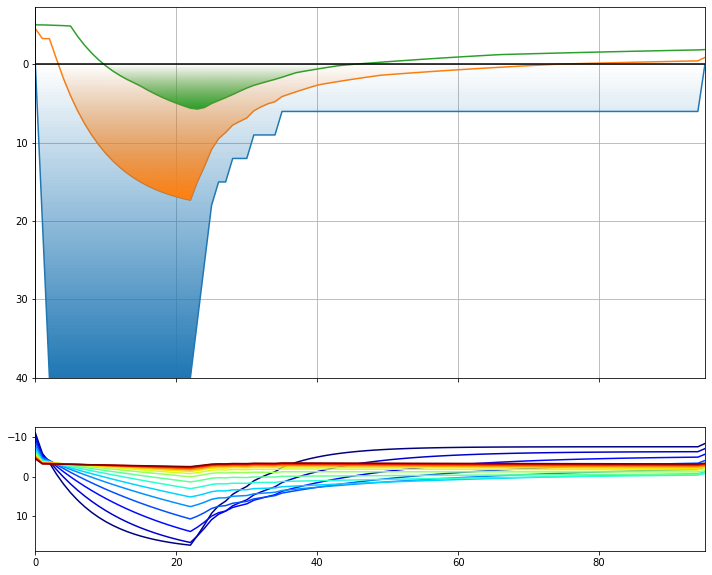

In [4]:
import pandas as pd
from buhlmann import Gas, Tissues, run_dive, get_stops_to_surface, depth_to_pressure, GradientFactors, ceiling_pressure_by_tissue, pressure_to_depth
gas = Gas(n2_pc=0.79, he_pc=0.0)
initial_tissues = Tissues()
dive_plan = pd.DataFrame([
    [0, 0],
    [2, 40],
    [22, 40]],
    columns=['t', 'depth'])

gf_lo = 0.3  # 30% GF LO
gf_hi = 0.8  # 30% GF LO

run_dive_plan = run_dive(dive_plan, initial_tissues, gas)
current_tissues = run_dive_plan.iloc[-1]['tissues']
current_depth = run_dive_plan.iloc[-1]['depth']
max_ascent_rate = 9  # metres/sec
run_stops = get_stops_to_surface(
    current_tissues,
    current_depth,
    gas,
    max_ascent_rate,
    gf_lo=gf_lo,
    gf_hi=gf_hi,
)
# print(run_stops)
depth_first_stop = run_dive_plan.iloc[-1]['depth']
t_first_stop = run_dive_plan.iloc[-1]['t']
run_stops['t'] += t_first_stop
run_dive_plan = run_dive_plan.append(run_stops)
print("==== DIVE PLAN ====\n{}".format(run_dive_plan))
# run with GF 1
dive_data = run_dive(
    run_dive_plan,
    initial_tissues,
    gas,
    resolution=1,
    gf=GradientFactors(1, depth_to_pressure(depth_first_stop), 1, depth_to_pressure(0), t_first_stop)
)
gf1_ceiling = dive_data['ceiling']

dive_data = run_dive(
    run_dive_plan,
    initial_tissues,
    gas,
    resolution=1,
    gf=GradientFactors(gf_lo, depth_to_pressure(depth_first_stop), gf_hi, depth_to_pressure(0), t_first_stop)
)
# print(dive_data)
all_tissues_data = pd.DataFrame(
    [ list(pressure_to_depth(ceiling_pressure_by_tissue(r.tissues, r.gf))) for r in dive_data.itertuples()],
    columns=['tissue{}'.format(n) for n in range(16)]
)
from matplotlib.patches import Polygon
import matplotlib.colors as mcolors

from dive_plan_graph import gradient_fill


%matplotlib inline
import math
import numpy as np
from matplotlib import pyplot as plt
t = np.linspace(0, 2*math.pi, 800)
a = np.sin(t)
plt.figure(figsize=(12, 10), dpi=75)
# plt.plot(dive_data['t'], dive_data['depth'], 'r')
# plt.plot(dive_data['t'], dive_data['ceiling'], 'b')
fig, axes = plt.subplots(nrows=2,figsize=(12,10),sharex="all", gridspec_kw={'height_ratios': [3, 1]})
ax1 = axes[0]
gradient_fill(dive_data['t'], dive_data['depth'], ax=ax1)
gradient_fill(dive_data['t'], dive_data['ceiling'], ax=ax1)
gradient_fill(dive_data['t'], gf1_ceiling, ax=ax1)
ax1.invert_yaxis()
plt.gca().invert_yaxis()
# ax.set_aspect('equal')
ax1.grid(True, which='both')
ax1.axhline(y=0, color='k')
ax1.axvline(x=0, color='k')

# add the 16 tissues ceilings
ax2 = axes[1]
n = 16
ax2.set_prop_cycle('color',[plt.cm.jet(i) for i in np.linspace(0, 1, n)])

for i in range(16):
    ax2.plot(dive_data['t'], all_tissues_data['tissue{}'.format(i)])

plt.show()